In [9]:
import tensorflow as tf 
from tensorflow import keras
import os 
import numpy as np 
import matplotlib.pyplot as plt
from glob import glob
import cv2
from scipy import ndimage
import sys 
import random 
from keras import backend as K


from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from albumentations import CenterCrop, RandomRotate90, GridDistortion, HorizontalFlip, VerticalFlip

In [10]:
# base_path = 'D:/Dropbox/WORK/SNUH/Atopy Segmentation'
base_path = 'C:/Users/user/Desktop/datasets/Atopy Segmentation'
# path_8 = os.path.join(base_path, 'Intersect_0.8')
paths = ['Intersect_0.75', 'Intersect_0.8', 'Intersect_0.85']
grades = ['Grade0', 'Grade1', 'Grade2', 'Grade3']

# path = paths[2]
# grade = grades[3]
# N_RES = 256
num_res = 256
num_classes = [0, 1, 2, 3]
grades_dict = {0 : 'Grade0', 1 : 'Grade1', 2 : 'Grade2', 3 : 'Grade3'}
num_batch = 16 
z_dim = 2

In [11]:
# x_train = {}
# y_train = {}

# x_test = {}
# y_test = {}

# x_extra = {}
# y_extra = {} 


# for path in paths:  
# for grade in grades:
train_list = glob(os.path.join(base_path, paths[2], 'Atopy_Segment_Train', f'*/*.jpg'))
# y_train_list = glob(os.path.join(base_path, paths[2], 'Atopy_Segment_Train', f'*/*.png'))

test_list = glob(os.path.join(base_path, paths[2], 'Atopy_Segment_Test', f'*/*.jpg'))
# y_test_list = glob(os.path.join(base_path, paths[2], 'Atopy_Segment_Test', f'*/*.png'))

extra_list = glob(os.path.join(base_path, paths[2], 'Atopy_Segment_Extra', f'*/*.jpg'))
# y_extra_list = glob(os.path.join(base_path, paths[2], 'Atopy_Segment_Extra', f'*/*.png'))

In [26]:
def create_dataset(data_list, dtype='train'):
    images = [] 
    masks = [] 
    labels = [] 
    
    for x in data_list:
        img = cv2.imread(x, cv2.COLOR_BGR2RGB)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (num_res, num_res)) / 255.
        
        y = x[:-4] + '.png'
        
        if os.path.isfile(y) == False:
            print(f'Not found mask file : {x}') 
            # none_mask += 1
            continue
        
        msk = cv2.imread(y, 0)
        msk = cv2.resize(msk, (num_res, num_res))
        msk[msk > 0] = 1.
        msk = np.float32(msk)

        lbl = np.float32(y.split('\\')[-2][-1])
        
        images.append(img) 
        masks.append(msk) 
        labels.append(lbl) 
        
        # if dtype == 'train':
        
        #     if np.random.randint(2) > 0:
        #         aug = RandomRotate90(p=1.0)
        #         augmented = aug(image=img, mask=msk)
        #         images.append(augmented['image'])
        #         masks.append(augmented['mask'])
        #         labels.append(lbl) 

        #     if np.random.randint(2) > 0:
        #         aug = GridDistortion(p=1.0)
        #         augmented = aug(image=img, mask=msk)
        #         images.append(augmented['image'])
        #         masks.append(augmented['mask'])
        #         labels.append(lbl) 

        #     if np.random.randint(2) > 0:
        #         aug = HorizontalFlip(p=1.0)
        #         augmented = aug(image=img, mask=msk)
        #         images.append(augmented['image'])
        #         masks.append(augmented['mask'])
        #         labels.append(lbl) 

        #     if np.random.randint(2) > 0:
        #         aug = VerticalFlip(p=1.0)
        #         augmented = aug(image=img, mask=msk)
        #         images.append(augmented['image'])
        #         masks.append(augmented['mask'])
        #         labels.append(lbl) 
        
    # 
    images = np.reshape(images, [-1, num_res, num_res, 3])
    masks = np.reshape(masks, [-1, num_res, num_res, 1])
    labels = np.reshape(labels, [-1, 1])
    
    # mixed_list = list(zip(images, masks, labels))
    # random.shuffle(mixed_list) # shuffle
    # images, masks, labels = zip(*mixed_list)
    idx = np.arange(images.shape[0])
    np.random.shuffle(idx) 
    
    images = images[idx]
    masks = masks[idx]
    labels = labels[idx]
    
    return images, masks, labels

In [27]:
train_images, train_masks, train_labels = create_dataset(train_list)
test_images, test_masks, test_labels = create_dataset(test_list, dtype='test')
extra_images, extra_masks, extra_labels = create_dataset(extra_list, dtype='extra')

train_images.shape, test_images.shape, extra_images.shape

Not found mask file : C:/Users/user/Desktop/datasets/Atopy Segmentation\Intersect_0.85\Atopy_Segment_Train\Grade2\0391.jpg
Not found mask file : C:/Users/user/Desktop/datasets/Atopy Segmentation\Intersect_0.85\Atopy_Segment_Train\Grade2\0807.jpg
Not found mask file : C:/Users/user/Desktop/datasets/Atopy Segmentation\Intersect_0.85\Atopy_Segment_Test\Grade1\8171.jpg
Not found mask file : C:/Users/user/Desktop/datasets/Atopy Segmentation\Intersect_0.85\Atopy_Segment_Test\Grade2\6990.jpg
Not found mask file : C:/Users/user/Desktop/datasets/Atopy Segmentation\Intersect_0.85\Atopy_Segment_Test\Grade2\6995.jpg
Not found mask file : C:/Users/user/Desktop/datasets/Atopy Segmentation\Intersect_0.85\Atopy_Segment_Test\Grade2\7331.jpg
Not found mask file : C:/Users/user/Desktop/datasets/Atopy Segmentation\Intersect_0.85\Atopy_Segment_Test\Grade2\7338.jpg
Not found mask file : C:/Users/user/Desktop/datasets/Atopy Segmentation\Intersect_0.85\Atopy_Segment_Extra\Grade1\9902.jpg


((1064, 256, 256, 3), (630, 256, 256, 3), (720, 256, 256, 3))

In [28]:
train_masks.shape, train_labels.shape

((1064, 256, 256, 1), (1064, 1))

c:\ProgramData\Miniconda3\lib\site-packages\matplotlib\text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


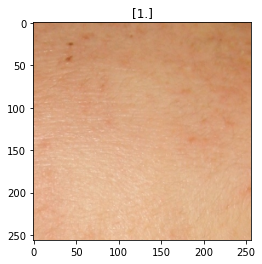

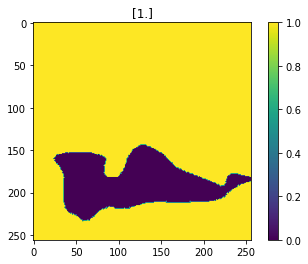

In [29]:
plt.imshow(train_images[1])
plt.title(train_labels[1])
plt.show() 

plt.imshow(train_masks[1])
plt.title(train_labels[1])
plt.colorbar()
plt.show()

In [20]:
class CVAE(tf.keras.Model):
    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        
        
    def encoder(self, x):
        x = tf.keras.layers.Input(input_shape=(num_res, num_res, 3))
        x = tf.keras.layers.Conv2D(32, 3, padding='same', strides=(2, 2), activation='relu')(x)
        x = tf.keras.layers.Conv2D(64, 3, padding='same', strides=(2, 2), activation='relu')(x)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Conv2D(32, activation='relu')(x)
        
        mean = tf.keras.layers.Dense(self.latent_dim)
        log_var = tf.keras.layers.Dense(self.latent_dim)
        return mean, log_var 

        self.decoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(latent_dim+1)),
                tf.keras.layers.Dense(units=64, activation='relu'),
                tf.keras.layers.Dropout(rate=0.2),
                tf.keras.layers.Dense(units=256, activation='relu'),
                tf.keras.layers.Dropout(rate=0.2),
                tf.keras.layers.Dense(units=512, activation='relu'),
                tf.keras.layers.Dense(units=784),
            ])

    @tf.function
    def encode(self, x, y):
        inputs = tf.concat([x, y], 1)
        mean, logvar = tf.split(self.encoder(inputs), num_or_size_splits=2, axis=1)
        stddev = 1e-8 + tf.nn.softplus(logvar)
        return mean, stddev

    def reparameterize(self, mean, stddev):
        eps = tf.random.normal(shape=mean.shape)
        z = mean + eps * stddev
        return z

    @tf.function
    def decode(self, z, y, apply_sigmoid=False):
        inputs = tf.concat([z, y], 1)
        logits = self.decoder(inputs)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

In [21]:
optimizer = tf.keras.optimizers.Adam(1e-4)

def compute_loss(model, x, y):
    x = tf.reshape(x, [-1, num_res, num_res])
    y = tf.reshape(y, [-1, 1])
    mean, stddev = model.encode(x, y)
    z = model.reparameterize(mean, stddev)
    x_logit = model.decode(z, y, True)
    x_logit = tf.clip_by_value(x_logit, 1e-8, 1-1e-8)

    # Loss
    marginal_likelihood = tf.reduce_sum(x * tf.math.log(x_logit) + (1 - x) * tf.math.log(1 - x_logit), axis=[1])
    loglikelihood = tf.reduce_mean(marginal_likelihood)

    kl_divergence = -0.5 * tf.reduce_sum(1 + tf.math.log(1e-8 + tf.square(stddev)) - tf.square(mean) - tf.square(stddev),
                                         axis=[1])
    kl_divergence = tf.reduce_mean(kl_divergence)

    ELBO = loglikelihood - kl_divergence
    loss = -ELBO

    return loss

In [22]:
@tf.function
def train_step(model, x, y, optimizer):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x, y)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss

In [23]:
epochs = 30
latent_dim = 2
model = CVAE(latent_dim)

# Train
for epoch in range(1, epochs + 1):
    train_losses = []
    for x, y in zip(train_images, train_labels):
        loss = train_step(model, x, y, optimizer)
        train_losses.append(loss)

    print('Epoch: {}, Loss: {:.2f}'.format(epoch, np.mean(train_losses)))


TypeError: in user code:

    File "C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_16604\403878734.py", line 4, in train_step  *
        loss = compute_loss(model, x, y)
    File "C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_16604\1944771825.py", line 6, in compute_loss  *
        mean, stddev = model.encode(x, y)
    File "C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_16604\1883564441.py", line 30, in encode  *
        inputs = tf.concat([x, y], 1)

    TypeError: Tensors in list passed to 'values' of 'ConcatV2' Op have types [float64, float32] that don't all match.
